<a href="https://colab.research.google.com/github/X-pose/DL_Lab_07/blob/main/lab_7_AE_CNN_Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[-0.7650597 ],
         [-1.2914159 ],
         [-0.34293762],
         ...,
         [ 1.7063533 ],
         [-0.23069449],
         [-0.66059273]],

        [[ 0.06418315],
         [ 0.94643015],
         [-1.9497077 ],
         ...,
         [-0.82696253],
         [ 1.1825695 ],
         [ 0.22775425]],

        [[-0.69174355],
         [ 1.0222412 ],
         [ 1.4883703 ],
         ...,
         [-2.349394  ],
         [ 0.16574602],
         [ 0.06321128]],

        ...,

        [[ 1.6889439 ],
         [-1.4571158 ],
         [-0.14362493],
         ...,
         [ 1.2285917 ],
         [-0.65963995],
         [ 0.5329067 ]],

        [[ 0.47036558],
         [ 0.5806316 ],
         [ 0.7309782 ],
         ...,
         [-1.2894974 ],
         [-0.98638475],
         [ 0.7058097 ]],

        [[ 0.57698584],
         [ 0.10443407],
         [ 0.53662974],
         ...,
         [-0.05397482],
         [ 0.480

In [6]:
noise_factor = 0.1
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

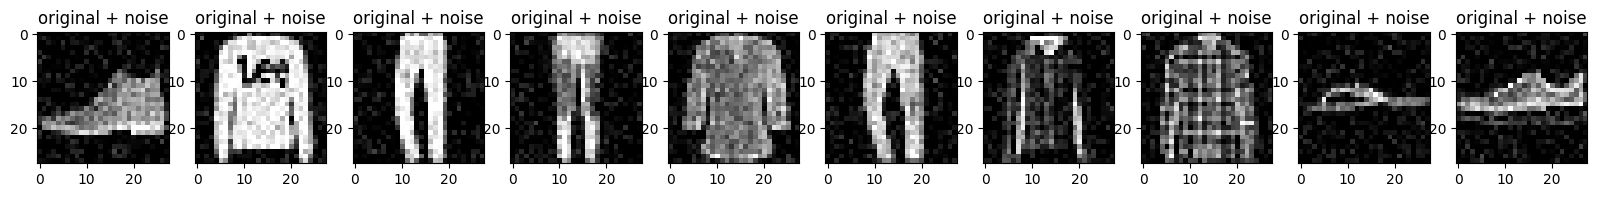

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
noisy_autoencoder_training = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0336 - val_loss: 0.0075
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 12/30
1875/1875 ━━━━━

In [13]:
#Code implementation to calculate the loss (Mean Squared Error) for the test dataset.
from sklearn.metrics import mean_squared_error

# Getting reconstructed images from the model
reconstructed_images = autoencoder.predict(x_test)

# Calculate Mean Squared Error for test dataset
mse = mean_squared_error(x_test.reshape(len(x_test), -1), reconstructed_images.reshape(len(reconstructed_images), -1))

print(f"Mean Squared Error (MSE) on Test Data: {mse}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error (MSE) on Test Data: 0.002663509687408805


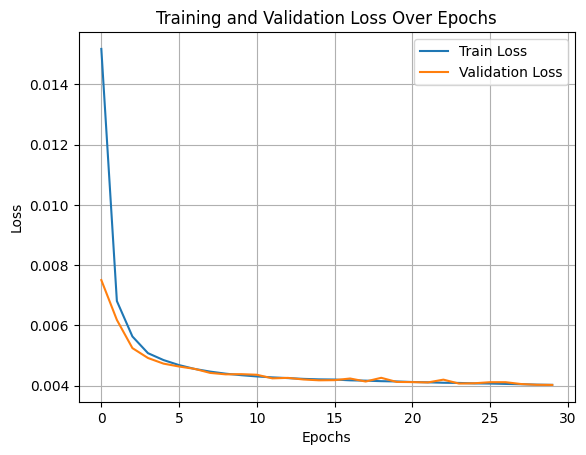

In [14]:
#Code implementation to plot the train and validation loss against number of epochs.
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.plot(noisy_autoencoder_training.history['loss'], label='Train Loss')
plt.plot(noisy_autoencoder_training.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
autoencoder.encoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
autoencoder.decoder.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

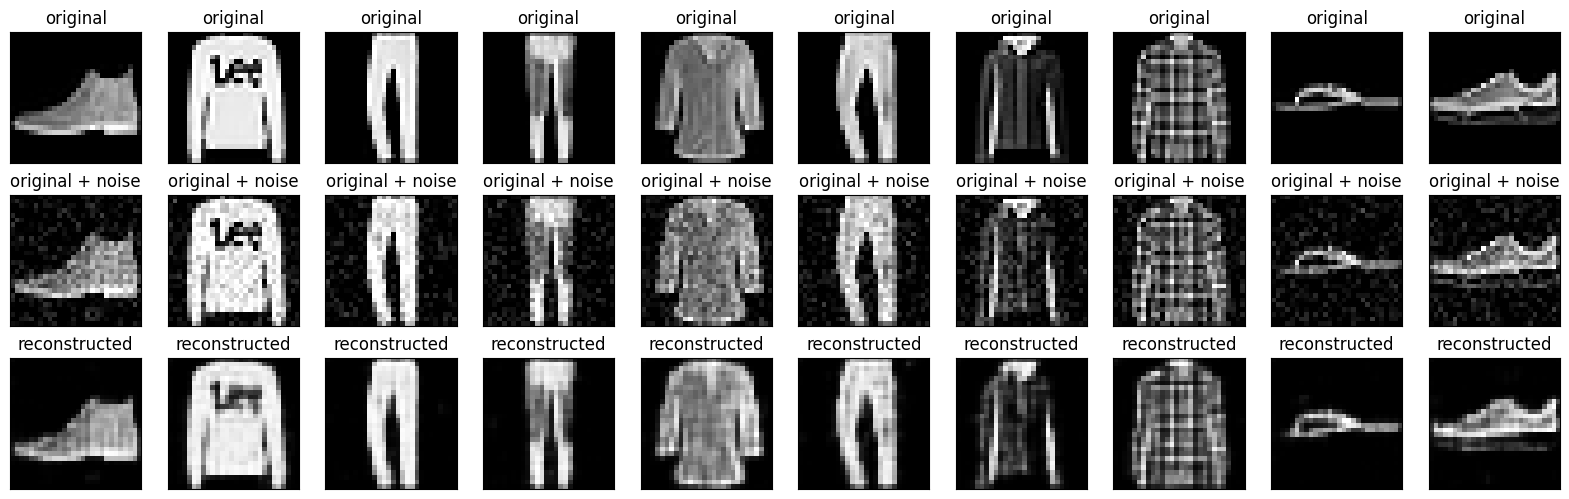

In [18]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()